### Required Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score,average_precision_score,f1_score,roc_curve
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from scipy import stats
from sklearn.model_selection import StratifiedKFold
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Read Data

In [2]:
wcct2=pd.read_csv("WCCT_data.csv")
norm=True
wcct2.head(3)

,VOLUNTEER,DPC,SHEDDER,B.cells.plasma.STAT5+,Basophils,Bcells,Bcells.CSM,Bcells.NCSM,Bcells.plasma,CD66+,...,Tcells.CD8+,Tcells.CD8+.CD161+,Tcells.CD8+.CD38+,Tcells.CD8+.CD38+Ki67+,Tcells.CD8+.Effector.CD38+,Tcells.CD8+.Effector.CD38+Ki67+,Tcells.CD8+.Memory,Tcells.CD8+.Memory.CD38+,Tcells.CD8+.Memory.CD38+Ki67+,Tcells.CD8+CD45RA+CD27-
0,101,Baseline 1,1,0.003108,1.712350,5.394990,1.103238,0.643297,0.046616,58.753327,...,14.736777,0.829759,0.180247,0.105662,0.015539,0.006215,4.583877,0.087016,0.065262,1.945429
1,101,Baseline 2,1,0.000000,1.545919,6.057033,1.218394,0.768593,0.026202,54.366529,...,16.153544,0.790428,0.231451,0.152845,0.017468,0.008734,4.908511,0.061138,0.056771,1.248963
2,101,1,1,0.000000,1.537663,5.168144,1.034428,0.571132,0.027958,66.719099,...,13.431584,0.635035,0.195703,0.131800,0.000000,0.000000,3.993929,0.095854,0.063903,1.282051


### Truncate columns

In [3]:
def truncate_columns(df, exclude_columns=None, decimals=5):
    if exclude_columns is None:
        exclude_columns = []
    # Select numeric columns excluding the specified ones
    cols_to_truncate = df.select_dtypes(include='number').columns.difference(exclude_columns)
    # Truncate (not round) to specified number of decimal places
    factor = 10 ** decimals
    df[cols_to_truncate] = df[cols_to_truncate].apply(lambda x: (x * factor).astype(int) / factor)
    return df

### Finding minimum non-zero values on a DataFrame

In [4]:
def min_nonzero(df, exclude_cols=["VOLUNTEER", "DPC", "SHEDDER"], per_column=True):
    # Drop excluded columns
    df_selected = df.drop(columns=exclude_cols, errors="ignore")
    # Replace zeros with NaN to exclude them
    df_nonzero = df_selected.replace(0, np.nan)
    if not per_column:
        return df_nonzero.min()
    else:
        return df_nonzero.min().min()  

### Preprocessing

In [5]:
min_nonzero(wcct2)
wcct2 = truncate_columns(
    wcct2,
    exclude_columns=['VOLUNTEER', 'DPC', 'SHEDDER'],  
    decimals=5)
wcct2.head(3)

,VOLUNTEER,DPC,SHEDDER,B.cells.plasma.STAT5+,Basophils,Bcells,Bcells.CSM,Bcells.NCSM,Bcells.plasma,CD66+,...,Tcells.CD8+,Tcells.CD8+.CD161+,Tcells.CD8+.CD38+,Tcells.CD8+.CD38+Ki67+,Tcells.CD8+.Effector.CD38+,Tcells.CD8+.Effector.CD38+Ki67+,Tcells.CD8+.Memory,Tcells.CD8+.Memory.CD38+,Tcells.CD8+.Memory.CD38+Ki67+,Tcells.CD8+CD45RA+CD27-
0,101,Baseline 1,1,0.0031,1.71235,5.39499,1.10323,0.64329,0.04661,58.75332,...,14.73677,0.82975,0.18024,0.10566,0.01553,0.00621,4.58387,0.08701,0.06526,1.94542
1,101,Baseline 2,1,0.0000,1.54591,6.05703,1.21839,0.76859,0.02620,54.36652,...,16.15354,0.79042,0.23145,0.15284,0.01746,0.00873,4.90851,0.06113,0.05677,1.24896
2,101,1,1,0.0000,1.53766,5.16814,1.03442,0.57113,0.02795,66.71909,...,13.43158,0.63503,0.19570,0.13179,0.00000,0.00000,3.99392,0.09585,0.06390,1.28205


In [6]:
def reverse_days(x):
    if x=="Baseline 1":
        return -1
    if x=="Baseline 2":
        return 1
    else:
        return int(x)+1 
wcct2["DPC"]=wcct2["DPC"].apply(lambda x:reverse_days(x))

In [7]:
#Rescale CD66+ and drop columns to ensure consistency with other values
to_drop = {
    "Tcells.CD4-CD8-",
    "Tcells.CD4-CD8-CD38+",
    "Tcells.CD4-CD8-CD38+Ki67+",
    "Tcells.CD8+",
    "Tcells.CD8+.CD38+",
    "Tcells.CD8+.CD38+Ki67+",
}
cols_to_drop = [c for c in wcct2.columns if c in to_drop]
wcct2 = wcct2.drop(columns=cols_to_drop, errors="ignore")
# Rescale CD66+ columns by dividing by 100
cd66_cols = [c for c in wcct2.columns if "CD66+" in c.upper()]
if cd66_cols:
    wcct2[cd66_cols] = wcct2[cd66_cols] / 100

### Baseline-Normalization

In [8]:
if norm == True:
    wcct2.loc[:,  (wcct2.columns != 'VOLUNTEER') &  (wcct2.columns != 'DPC') & (wcct2.columns != 'SHEDDER')] = \
        wcct2.loc[:,  (wcct2.columns != 'VOLUNTEER') &  (wcct2.columns != 'DPC') & (wcct2.columns != 'SHEDDER')].subtract(
        (wcct2.groupby('VOLUNTEER').transform(lambda x:x.iloc[0])))#.round(2)
    wcct2.head()

### Filter unwanted days out

In [9]:
wcct2=wcct2[~wcct2["DPC"].isin([-1,29,60])] 
wcct2.head(3)
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    #print('ROC AUC:', auc)
    #print('PR AUC:', pr)
    #print('F1 score:', f_score)
    #print(confusion_matrix(true, bin_pred, normalize='true'))
    return auc, pr, f_score

### Random Forest Classifier

In [10]:
train_days = [2, 3, 4, 5, 6, 7, 8] 
for d in train_days:
    xw=wcct2[wcct2["DPC"]==d].drop(["VOLUNTEER","DPC","SHEDDER"],axis=1)
    yw=wcct2[wcct2["DPC"]==d]["SHEDDER"]
    aucs=[]
    for j in range(100):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED + j)
        rf = RandomForestClassifier(random_state=SEED + j)
        for i,(train,test) in enumerate(cv.split(xw,yw)):
            rf.fit(xw.iloc[train],yw.iloc[train])
            test_preds=rf.predict_proba(xw.iloc[test])[:,1]
            auc,pr,f_score=evaluate_preds(yw.iloc[test],test_preds)
            aucs.append(auc)
    print(d-1,np.mean(aucs))

1 0.48675
2 0.6368333333333333
3 0.78825
4 0.8486666666666668
5 0.82575
6 0.88525
7 0.8944166666666666


### ROC Curve per Day

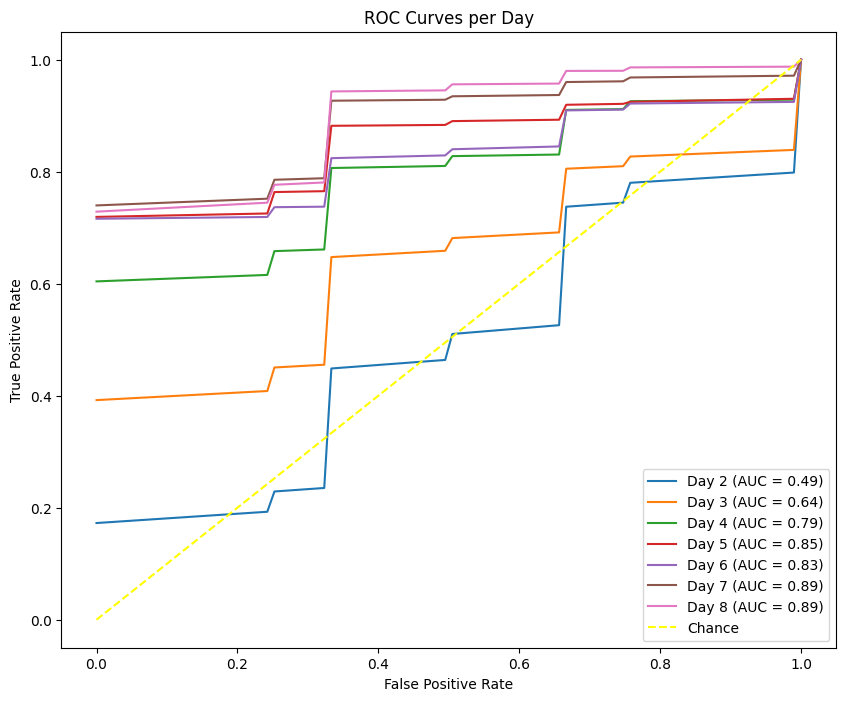

In [11]:
train_days=[2,3,4,5,6,7,8]
plt.figure(figsize=(10,8))
for d in train_days:
    yw=wcct2[wcct2["DPC"]==d]["SHEDDER"]
    xw=wcct2[wcct2["DPC"]==d].drop(["VOLUNTEER","DPC","SHEDDER"],axis=1)
    aucs=[]
    all_tpr = []
    all_fpr = []
    mean_tpr = None
    mean_fpr = np.linspace(0, 1, 100)  
    for j in range(100):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED + j)
        rf = RandomForestClassifier(random_state=SEED + j)
        for i, (train, test) in enumerate(cv.split(xw, yw)):
            rf.fit(xw.iloc[train], yw.iloc[train])
            test_preds = rf.predict_proba(xw.iloc[test])[:, 1]
            fpr, tpr, _ = roc_curve(yw.iloc[test], test_preds)
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            auc_ = roc_auc_score(yw.iloc[test], test_preds)
            aucs.append(auc_)
            all_fpr.append(mean_fpr)
            all_tpr.append(tpr_interp)
    mean_tpr = np.mean(all_tpr, axis=0)
    mean_auc = np.mean(aucs)
    plt.plot(mean_fpr, mean_tpr, label=f'Day {d} (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], '--', label='Chance', color='yellow')
plt.title('ROC Curves per Day')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Select shedders

In [12]:
wcct2=wcct2[wcct2["SHEDDER"]==1].copy()
wcct2 = wcct2[~wcct2['VOLUNTEER'].isin([101,109,304])]

### Random Forest Regressor

In [13]:
trus=[]
preds=[]
to_write=pd.DataFrame()
ids=wcct2["VOLUNTEER"].unique()
for n, id_ in enumerate(ids):
    for d in range(1,9):
        test = wcct2[(wcct2['VOLUNTEER']==id_) & (wcct2['DPC']==d)]
        if test.empty:
            continue
        regr = RandomForestRegressor(random_state=SEED)
        train = wcct2[(wcct2['VOLUNTEER']!=id_)]
        X_tr = train.drop(['VOLUNTEER','DPC','SHEDDER'], axis=1)
        Y_tr = train['DPC']
        X_te = test.drop(['VOLUNTEER','DPC','SHEDDER'], axis=1)
        Y_te = test['DPC']
        regr.fit(X_tr, Y_tr)
        pr = regr.predict(X_te)
        trus.extend(Y_te)
        preds.extend(pr)
correlation, p_value = stats.pearsonr(trus,preds)
correlation, p_value

(0.879666267444837, 1.7261615855108346e-42)

### Scatter Plot of True vs Predicted Values
### Median Line, regression line, 95% confidence Interval, Pearson correlation coefficient and p-value

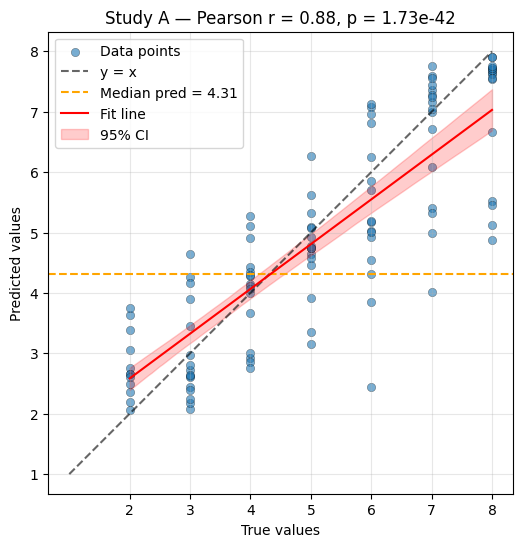

In [14]:
def plot_scatter_with_ci(y_true, y_pred, n_bootstrap=1000):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r, p = stats.pearsonr(y_true, y_pred)
    plt.figure(figsize=(6,6))
    mask = (y_true >= 2) & (y_true <= 8) & (y_pred >= 2) & (y_pred <= 8)
    plt.scatter(y_true[mask], y_pred[mask],
                alpha=0.6, edgecolors="black", linewidths=0.3, label="Data points")
    lims = [1, 8]  
    plt.plot(lims, lims, 'k--', alpha=0.6, label="y = x")
    median_pred = np.median(y_pred)
    plt.axhline(median_pred, color="orange", linestyle="--", label=f"Median pred = {median_pred:.2f}")
    slope, intercept, _, _, _ = stats.linregress(y_true, y_pred)
    x_line = np.linspace(2, y_true.max(), 100)
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, color="red", label="Fit line")
    boot_lines = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        s, i, _, _, _ = stats.linregress(y_true[idx], y_pred[idx])
        boot_lines.append(s * x_line + i)
    boot_lines = np.array(boot_lines)

    low_line = np.percentile(boot_lines, 2.5, axis=0)
    high_line = np.percentile(boot_lines, 97.5, axis=0)
    plt.fill_between(x_line, low_line, high_line, color="red", alpha=0.2, label="95% CI")
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title(f"Study A — Pearson r = {r:.2f}, p = {p:.2e}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(1, 8)
    plt.ylim(1, 8)
    plt.xticks([2,3,4,5,6,7,8]) 
    plt.axis("equal")
    plt.margins(x=0.05, y=0.05)
    plt.show()
if __name__ == "__main__":
    plot_scatter_with_ci(trus, preds)

### rMSE
### preds:list of predicted days
### trus:list of true days

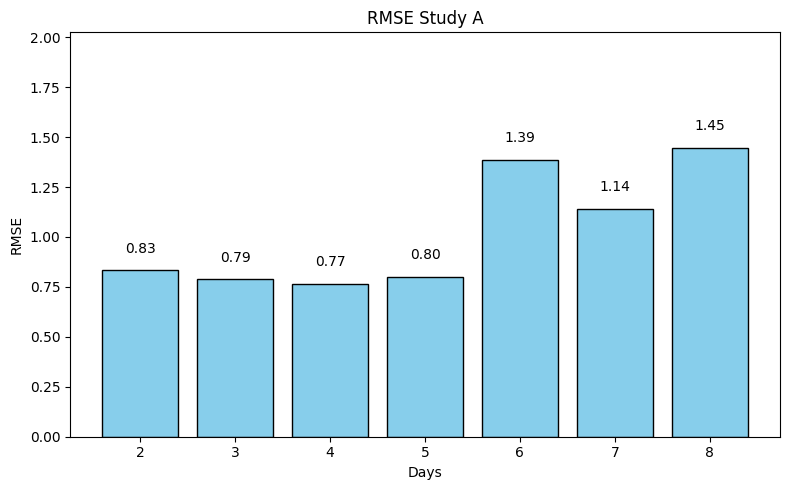

In [15]:
def plot_daywise_rmse(preds, trus):
    preds = np.array(preds)
    trus = np.array(trus)
    mask = (trus >= 2) & (trus <= 8)
    preds = preds[mask]
    trus = trus[mask]
    unique_days = np.unique(trus)
    rmses = []
    for d in unique_days:
        day_mask = trus == d
        rmse = np.sqrt(np.mean((preds[day_mask] - trus[day_mask]) ** 2))
        rmses.append(rmse)
    labels = [str(d) for d in unique_days]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, rmses, color="skyblue", edgecolor="black")
    plt.ylabel("RMSE")
    plt.xlabel("Days")
    plt.title("RMSE Study A")
    for bar, val in zip(bars, rmses):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + (max(rmses) * 0.05),
                 f"{val:.2f}",
                 ha="center", va="bottom", fontsize=10)
    plt.ylim(0, max(rmses) * 1.4)
    plt.tight_layout()
    plt.show()
plot_daywise_rmse(preds, trus)

### Heatmap Study A
### Predicted vs actual DPC by Subject

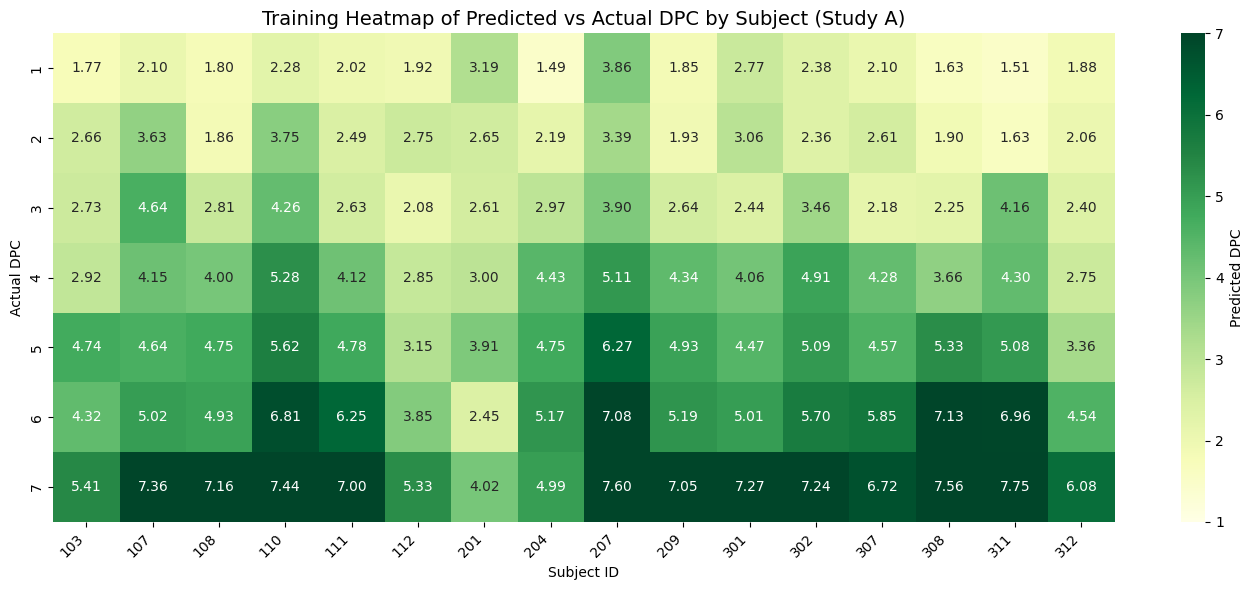

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df_train = pd.DataFrame({
    "SubjectID": wcct2.loc[wcct2["SHEDDER"] == 1, "VOLUNTEER"].astype(str).values,
    "Actual_DPC": np.array(trus),
    "Predicted_DPC": np.array(preds)
})
mask = (df_train["Actual_DPC"] >= 1) & (df_train["Actual_DPC"] <= 7)
df_train = df_train[mask]
heatmap_df = pd.pivot_table(
    df_train,
    index="Actual_DPC",
    columns="SubjectID",
    values="Predicted_DPC",
    aggfunc="median"
)
heatmap_df = heatmap_df.interpolate(axis=1, limit_direction="both")
heatmap_df = heatmap_df.interpolate(axis=0, limit_direction="both")
heatmap_df = heatmap_df.fillna(heatmap_df.mean(numeric_only=True))
heatmap_df = heatmap_df.sort_index()
try:
    heatmap_df = heatmap_df.reindex(sorted(heatmap_df.columns, key=lambda x: int(x)), axis=1)
except Exception:
    heatmap_df = heatmap_df.reindex(sorted(heatmap_df.columns), axis=1)
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    heatmap_df,
    vmin=min(df_train["Actual_DPC"]), vmax=max(df_train["Actual_DPC"]),
    cmap="YlGn",
    annot=True, fmt=".2f",
    cbar_kws={"label": "Predicted DPC"}
)
ax.set_title("Training Heatmap of Predicted vs Actual DPC by Subject (Study A)", fontsize=14)
ax.set_xlabel("Subject ID")
ax.set_ylabel("Actual DPC")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()